# Predict player position

### Name of the people who worked on this project together

**Sangani Bhavin Pravinbhai**

**Himanshu Bhardwaj**

**Lakshmanan L**

**P Ashish**

## Contents:
* [Reading and Viewing dataset](#first-bullet)
* [Basic Data manipulation](#second-bullet)
* [Basic EDA](#third-bullet)
* [Model Building](#fourth-bullet)
* [Logistic Regression](#fifth-bullet)
* [Neural Network](#sixth-bullet)
* [Predicting for 2020](#seventh-bullet)
* [Predicting only for test set](#eighth-bullet)
* [Final Accuracy for test set](#ninth-bullet)
* [Test set results - graphical representation](#tenth-bullet)

In [63]:
import pandas as pd
import numpy as np
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout

warnings.simplefilter("ignore")

pd.set_option("display.max_columns",500)
pd.set_option('display.max_rows', 500)

## Reading and Viewing Data 2019 FIFA Dataset <a class="anchor" id="first-bullet"></a>

In [2]:

fdata = pd.read_csv("Data/players_19.csv")
fdata.head(3)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,FC Barcelona,...,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3


In [65]:
## Selecting only relevant columns of information for futher analysis
del fdata['player_url'] 
del fdata['long_name']
del fdata['nationality']
del fdata['club']
del fdata['potential']
del fdata['real_face']
del fdata['team_position']
del fdata['team_jersey_number']
del fdata['nation_position']
del fdata['nation_jersey_number']
del fdata['player_traits']
del fdata['player_tags']
del fdata['value_eur']
del fdata['wage_eur']

In [66]:
del fdata['dob']

In [67]:
fdata.head(3)

,sofifa_id,short_name,age,height_cm,weight_kg,overall,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,release_clause_eur,loaned_from,joined,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,Cristiano Ronaldo,33,187,83,94,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,127100000.0,NaN,2018-07-10,2022.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,L. Messi,31,170,72,94,"CF, RW, ST",Left,5,4,4,Medium/Medium,Messi,226500000.0,NaN,2004-07-01,2021.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,90+2,84+2,84+2,84+2,90+2,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,Neymar Jr,26,175,68,92,"LW, CAM",Right,5,5,5,High/Medium,Neymar,228100000.0,NaN,2017-08-03,2022.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3


## Basic Data Manipulation <a class="anchor" id="second-bullet"></a>

In [68]:
# Convert Player poistion into a single column and create as many duplicates as necessary
# On second thoughts selecting the first position alone

fdata['Position 1'] = fdata['player_positions'].str.split(',',expand=True)[0]
fdata['Position 2'] = fdata['player_positions'].str.split(',',expand=True)[1]
fdata['Position 3'] = fdata['player_positions'].str.split(',',expand=True)[2]
fdata['Position 4'] = fdata['player_positions'].str.split(',',expand=True)[3]

data1 = fdata[~fdata['Position 1'].isna()].iloc[:,np.r_[0:90]]
data2 = fdata[~fdata['Position 2'].isna()].iloc[:,np.r_[0:89,90]]
data2.columns = data1.columns
data3 = fdata[~fdata['Position 3'].isna()].iloc[:,np.r_[0:89,91]]
data3.columns = data1.columns
data4 = fdata[~fdata['Position 4'].isna()].iloc[:,np.r_[0:89,92]]
data4.columns = data1.columns

#fdata = data1.append(data2)
#fdata = fdata.append(data3)
#fdata = fdata.append(data4)

fdata = data1.copy()

fdata['player_positions'] = fdata['Position 1']
del fdata['Position 1']

In [69]:
#len(data1)+len(data2)+len(data3)+len(data4) == len(fdata)

False

In [70]:
#fdata['preferred_foot'].value_counts()

Right    13639
Left      4131
Name: preferred_foot, dtype: int64

In [71]:
#fdata['international_reputation'].value_counts()

1    16114
2     1282
3      317
4       51
5        6
Name: international_reputation, dtype: int64

In [72]:
#fdata['weak_foot'].value_counts()

3    11083
2     3711
4     2613
5      218
1      145
Name: weak_foot, dtype: int64

In [73]:
#fdata['skill_moves'].value_counts()

2    8586
3    6299
1    1986
4     851
5      48
Name: skill_moves, dtype: int64

In [74]:
#fdata['work_rate'].value_counts()

Medium/Medium    9621
High/Medium      3152
Medium/High      1628
High/High         976
Medium/Low        814
High/Low          682
Low/Medium        443
Low/High          423
Low/Low            31
Name: work_rate, dtype: int64

In [75]:
#Keep only 3 main types
fdata['body_type'] = np.where(fdata['body_type'].isin(['Normal','Lean','Stocky']),fdata['body_type'],'Normal')

In [76]:
#Converting it into a 1 or 0 column
fdata['loaned_from'] = np.where(fdata['loaned_from'].isna,0,1)

In [77]:
#Changing into age (reminder to change to 2020 while doing 2020 data)
fdata['club_age'] = 2019 - pd.to_datetime(fdata['joined'],format='%Y-%m-%d').dt.year
del fdata['joined']

In [78]:
#Changing into remaining years - reminder to change to 2020 for 2020 dataset
fdata['contract_valid_until'] = fdata['contract_valid_until'] - 2019

In [79]:
#Wherever the + or - is found, get only the main number
colname_list = [ 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb']

for i in range(len(colname_list)):
    fdata[colname_list[i]] = fdata[colname_list[i]].str.replace('+',';')
    fdata[colname_list[i]] = fdata[colname_list[i]].str.replace('-',';')
    fdata[colname_list[i]] = fdata[colname_list[i]].str.split(';',expand=True)[0].fillna(0).astype('int')

In [80]:
#Substituting all null values with mode 
for column in fdata.columns:
    fdata[column].fillna(fdata[column].mode()[0], inplace=True)

In [81]:
fdata.columns

Index(['sofifa_id', 'short_name', 'age', 'height_cm', 'weight_kg', 'overall',
       'player_positions', 'preferred_foot', 'international_reputation',
       'weak_foot', 'skill_moves', 'work_rate', 'body_type',
       'release_clause_eur', 'loaned_from', 'contract_valid_until', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_p

## Basic EDA <a class="anchor" id="third-bullet"></a>

<AxesSubplot:xlabel='player_positions', ylabel='overall'>

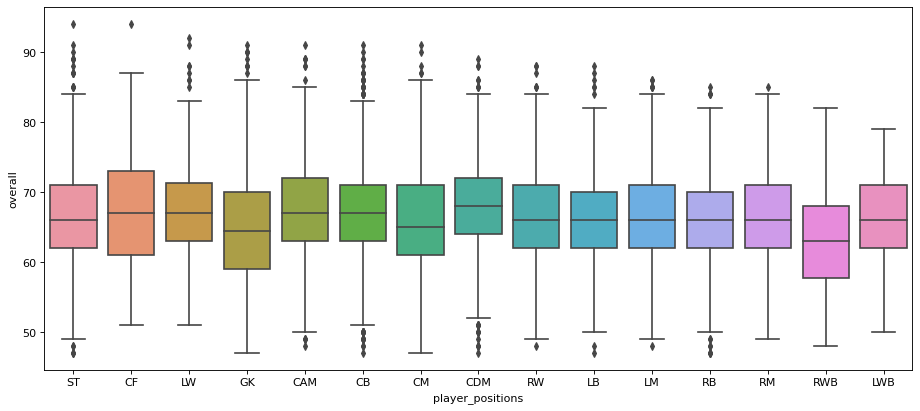

In [82]:
## See spread of overall metric as a function of different playing poistions 
##- a player's position doesnt seem to affect his rating much
from matplotlib.pyplot import figure
figure(figsize=(14, 6), dpi=80)

sns.boxplot(x="player_positions", y="overall", data=fdata)

<AxesSubplot:xlabel='player_positions', ylabel='attacking_crossing'>

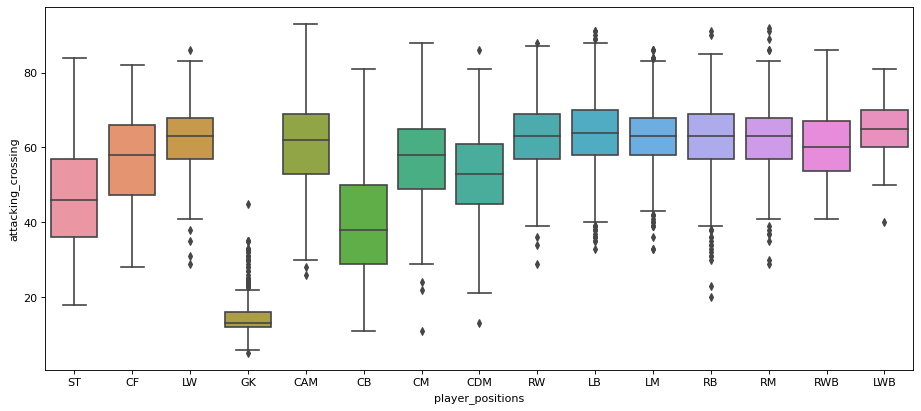

In [83]:
## Change the column name to see the spread for other columns 
##-picked attacking crossing; goal keepers have less skill in attacking crossing makes sense
from matplotlib.pyplot import figure
figure(figsize=(14, 6), dpi=80)

sns.boxplot(x="player_positions", y="attacking_crossing", data=fdata)

## Model Building <a class="anchor" id="fourth-bullet"></a>

In [84]:
#remove extra spaces 
fdata['player_positions'] = fdata['player_positions'].str.strip()

In [85]:
#Label encode the y variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
fdata['player_positions'] = label_encoder.fit_transform(fdata['player_positions'])

In [86]:
fdata.head(3)

,sofifa_id,short_name,age,height_cm,weight_kg,overall,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,release_clause_eur,loaned_from,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,club_age
0,20801,Cristiano Ronaldo,33,187,83,94,14,Right,5,4,5,High/Low,Normal,127100000.0,0,3.0,90.0,93.0,81.0,89.0,35.0,79.0,63.0,65.0,60.0,64.0,45.0,65.0,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,1.0
1,158023,L. Messi,31,170,72,94,3,Left,5,4,4,Medium/Medium,Normal,226500000.0,0,2.0,88.0,91.0,88.0,96.0,32.0,61.0,63.0,65.0,60.0,64.0,45.0,65.0,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88,88,88,92,93,93,93,92,93,93,93,90,84,84,84,90,63,61,61,61,63,58,47,47,47,58,15.0
2,190871,Neymar Jr,26,175,68,92,8,Right,5,5,5,High/Medium,Normal,228100000.0,0,3.0,92.0,84.0,83.0,95.0,32.0,59.0,63.0,65.0,60.0,64.0,45.0,65.0,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,2.0


In [87]:
#Convert the categorical columns into one hot encoding
fdata = pd.get_dummies(fdata,columns=['preferred_foot','work_rate','body_type'])

In [88]:
#Getting X and Y
X = fdata.loc[:, ~fdata.columns.isin(['player_positions','sofifa_id','short_name'])]
y = fdata[['player_positions']]

In [89]:
#Random Train test split
X_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.75,random_state=3)

## Training a simple logistic regression <a class="anchor" id="fifth-bullet"></a>

In [90]:
estimator = LogisticRegression()

In [91]:
selector = estimator.fit(X_train, y_train)

In [92]:
predictions = selector.predict(x_test)

In [93]:
accuracy_score(predictions,y_test)

0.16948008102633355

In [94]:
#multilabel_confusion_matrix(predictions,y_test)

In [95]:
##Training a simple xgboost - xg boost gives around 65% accuracy compared to 15% accuracy in logistic regression

# from xgboost import XGBClassifier
# model = XGBClassifier()
# model.fit(X_train, y_train)
# y_pred = model.predict(x_test)
# print(accuracy_score(y_pred,y_test))
# feature_importance = model.get_booster().get_score(importance_type='weight')
# import operator
# feature_importance2 = sorted(feature_importance.items(),key=operator.itemgetter(1),reverse=True)
# feature_importance2

#### Logistic regression gives very less accuracy compared to an out of the box xgboost model,lets' try neural network. If that doesnt work, then let's work on logistic regression to improve it's acccuracy

## Building a classification neural network <a class="anchor" id="sixth-bullet"></a>

In [96]:
X = fdata.loc[:, ~fdata.columns.isin(['player_positions','sofifa_id','short_name'])]
y = fdata[['player_positions']]

In [97]:
#Standardising makes a lot of differnece to neural network - tried with and without
sc = StandardScaler()
X = sc.fit_transform(X)

In [98]:
#One hot encoder for the final 14 levels
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [99]:
#Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=3)

In [100]:
model = Sequential()

# Neural network - input dimentions is shape of X. ## keeping the activation function as relu. 
##Number of nodes of 30 was chosen after trial an error
model.add(Dense(30, input_dim=97, activation='relu'))

## Adding a dropout layer since the model was overfitting. 
model.add(Dropout(0.2))

## Output dimention is the final layer with 15 nodes. It is a softmax regression
model.add(Dense(15, activation='softmax'))

In [101]:
##Setting an early stopping with patience of 20 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [102]:
## After trying the following loss funcitons, cosine similarity seems to work the best. Keeping the optimizer as adam
#Categorical Cross Entropy 
#CosineSimilarity
#CategoricalHinge

model.compile(loss='CosineSimilarity', optimizer='adam', metrics=['accuracy'])

In [103]:
##Training the model for 200 epoch, with early stopping and batch size of 50. Trial and Error
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=200, batch_size=50, callbacks=[callback])

Epoch 1/200
285/285 [==============================] - 1s 1ms/step - loss: -0.5831 - accuracy: 0.5303 - val_loss: -0.7297 - val_accuracy: 0.6913
Epoch 2/200
285/285 [==============================] - 0s 1ms/step - loss: -0.7201 - accuracy: 0.6717 - val_loss: -0.7647 - val_accuracy: 0.7214
Epoch 3/200
285/285 [==============================] - 0s 1ms/step - loss: -0.7449 - accuracy: 0.7022 - val_loss: -0.7779 - val_accuracy: 0.7400
Epoch 4/200
285/285 [==============================] - 0s 1ms/step - loss: -0.7572 - accuracy: 0.7153 - val_loss: -0.7860 - val_accuracy: 0.7515
Epoch 5/200
285/285 [==============================] - 0s 1ms/step - loss: -0.7652 - accuracy: 0.7227 - val_loss: -0.7913 - val_accuracy: 0.7558
Epoch 6/200
285/285 [==============================] - 0s 1ms/step - loss: -0.7717 - accuracy: 0.7306 - val_loss: -0.7943 - val_accuracy: 0.7572
Epoch 7/200
285/285 [==============================] - 0s 1ms/step - loss: -0.7761 - accuracy: 0.7386 - val_loss: -0.7974 - val_ac

In [104]:
# To pring the accuracy

y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))
    
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 77.96848621271806


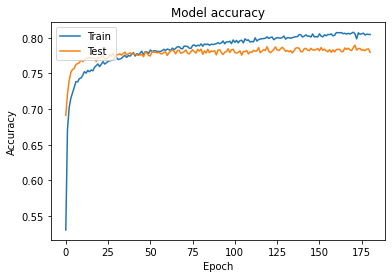

In [105]:
## PLotting model accuracy for both train and test

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

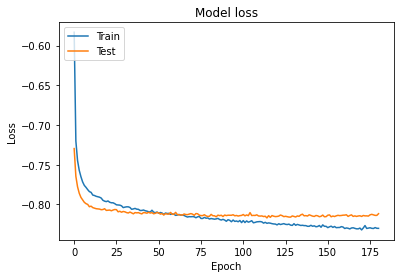

In [106]:
## PLotting model accuracy for both train and test

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## Predicting for the 2020 dataset and the select list <a class="anchor" id="seventh-bullet"></a>

In [148]:
fdata20 = pd.read_csv("Data/players_20.csv")
fdata20.head(3)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Argues with Officials, Earl...",88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,"Long Throw-in, Selfish, Argues with Officials,...",84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Injury Free, Selfish, Early C...",87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3


In [149]:
selectlist = ['FC Barcelona','Juventus','Paris Saint-Germain','Real Madrid','Atlético Madrid','Manchester City','Manchester United','Liverpool','FC Bayern München']
sel_sofifa_id = fdata20[fdata20.club.isin(selectlist)]['sofifa_id']

In [150]:
## Selecting only relevant columns of information for futher analysis
del fdata20['player_url'] 
del fdata20['long_name']
del fdata20['nationality']
del fdata20['club']
del fdata20['potential']
del fdata20['real_face']
del fdata20['team_position']
del fdata20['team_jersey_number']
del fdata20['nation_position']
del fdata20['nation_jersey_number']
del fdata20['player_traits']
del fdata20['player_tags']
del fdata20['dob']
del fdata20['value_eur']
del fdata20['wage_eur']

In [151]:
# Convert Player poistion into a single column and create as many duplicates as necessary
fdata20['Position 1'] = fdata20['player_positions'].str.split(',',expand=True)[0]

data1 = fdata20[~fdata20['Position 1'].isna()].iloc[:,np.r_[0:90]]
fdata20 = data1.copy()

fdata20['player_positions'] = fdata20['Position 1']
del fdata20['Position 1']

In [152]:
fdata20['body_type'] = np.where(fdata20['body_type'].isin(['Normal','Lean','Stocky']),fdata20['body_type'],'Normal')
fdata20['loaned_from'] = np.where(fdata20['loaned_from'].isna,0,1)
fdata20['club_age'] = 2020 - pd.to_datetime(fdata20['joined'],format='%Y-%m-%d').dt.year
del fdata20['joined']
fdata20['contract_valid_until'] = fdata20['contract_valid_until'] - 2020

In [153]:
colname_list = [ 'ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb']

for i in range(len(colname_list)):
    fdata20[colname_list[i]] = fdata20[colname_list[i]].str.replace('+',';')
    fdata20[colname_list[i]] = fdata20[colname_list[i]].str.replace('-',';')
    fdata20[colname_list[i]] = fdata20[colname_list[i]].str.split(';',expand=True)[0].fillna(0).astype('int')

In [154]:
for column in fdata20.columns:
    fdata20[column].fillna(fdata20[column].mode()[0], inplace=True)

In [155]:
fdata20['player_positions'] = fdata20['player_positions'].str.strip()

In [156]:
fdata20.shape

(18278, 89)

In [157]:
#from sklearn.preprocessing import LabelEncoder
#label_encoder = LabelEncoder()
fdata20['player_positions'] = label_encoder.transform(fdata20['player_positions'])
fdata20 = pd.get_dummies(fdata20,columns=['preferred_foot','work_rate','body_type'])

In [158]:
X = fdata20.loc[:, ~fdata.columns.isin(['player_positions','sofifa_id','short_name'])]
X = sc.transform(X)
y = fdata20[['player_positions']]
y = ohe.transform(y).toarray()

In [159]:
y_pred = model.predict(X)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y)):
    test.append(np.argmax(y[i]))
    
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 73.02221249589671


## Predicting only for the test set in FIFA 20 <a class="anchor" id="eighth-bullet"></a>

#### Test Set: Players from the following Clubs 

1) FC Barcelona
2) FC Bayern München
3) Real Madrid 
4) Paris Saint-Germain
5) Juventus
6) Atlético Madrid
7) Manchester City
8) Liverpool 
9) Manchester United

In [160]:
fdata20_sel = fdata20[fdata20.sofifa_id.isin(sel_sofifa_id)]

In [161]:
X = fdata20_sel.loc[:, ~fdata.columns.isin(['player_positions','sofifa_id','short_name'])]
X = sc.transform(X)
y = fdata20_sel[['player_positions']]
y = ohe.transform(y).toarray()

In [162]:
y_pred = model.predict(X)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y)):
    test.append(np.argmax(y[i]))
    
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 74.21602787456446


#### Accuracies (assuming match of the first preferred player position)

1) Train Accuracy - 80%

2) Test Accuracy - 78%

3) 2020 Accuracy - 73%

4) 2020 select player accuracy - 74%

#### The drop is because of changing patterns between 2019 and 2020. If we were to train on 2020 and predict on the test set of select players, we should be able to get better predictions


## Final test set accuracy <a class="anchor" id="ninth-bullet"></a>
### Reevaluating the accuracy to mark as correct if the predicted position is one amongst the list of player positions

In [228]:
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
print(label_mapping)

{0: 'CAM', 1: 'CB', 2: 'CDM', 3: 'CF', 4: 'CM', 5: 'GK', 6: 'LB', 7: 'LM', 8: 'LW', 9: 'LWB', 10: 'RB', 11: 'RM', 12: 'RW', 13: 'RWB', 14: 'ST'}


In [229]:
fdata20_sel['player_positions_actual'] = fdata20_sel['player_positions'].replace(label_mapping)
fdata20_sel['player_postion_predicted'] = list(pred)
fdata20_sel['player_postion_predicted'] = fdata20_sel['player_postion_predicted'].replace(label_mapping)

In [230]:
details = pd.read_csv(r"../Data/players_20.csv")
#details.head(3)

In [234]:
accuracy_data = fdata20_sel[['sofifa_id','short_name','player_positions_actual','player_postion_predicted']].merge(details[['sofifa_id','club','player_positions']].drop_duplicates(),how='left')

In [233]:
accuracy_data.head(3)

,sofifa_id,short_name,player_positions_actual,player_postion_predicted,club,player_positions
0,158023,L. Messi,RW,RW,FC Barcelona,"RW, CF, ST"
1,20801,Cristiano Ronaldo,ST,ST,Juventus,"ST, LW"
2,190871,Neymar Jr,LW,RW,Paris Saint-Germain,"LW, CAM"


In [246]:
accuracy_data['One_Correct'] = accuracy_data.apply(lambda x: x.player_postion_predicted in x.player_positions, axis=1)
accuracy_data['One_Correct'] = np.where(accuracy_data['One_Correct']==True,1,0)

In [247]:
accuracy_data['One_Correct'].mean()

0.8780487804878049

## The final accuracy for the test set players is 88% - This is taking if the predicted position is one of the actual player positions

## Graphical Representation for the test results <a class="anchor" id="tenth-bullet"></a>

In [252]:
byclub = pd.pivot_table(accuracy_data,index=['club'],values='One_Correct',aggfunc=[len,np.mean],fill_value=0).reset_index(drop=False)
byclub.columns = ['club','# of players','% correctly classified']
byclub['% correctly classified'] = round(byclub['% correctly classified']*100,1)
byclub.head(3)

,club,# of players,% correctly classified
0,Atlético Madrid,33,87.9
1,FC Barcelona,33,97.0
2,FC Bayern München,23,91.3


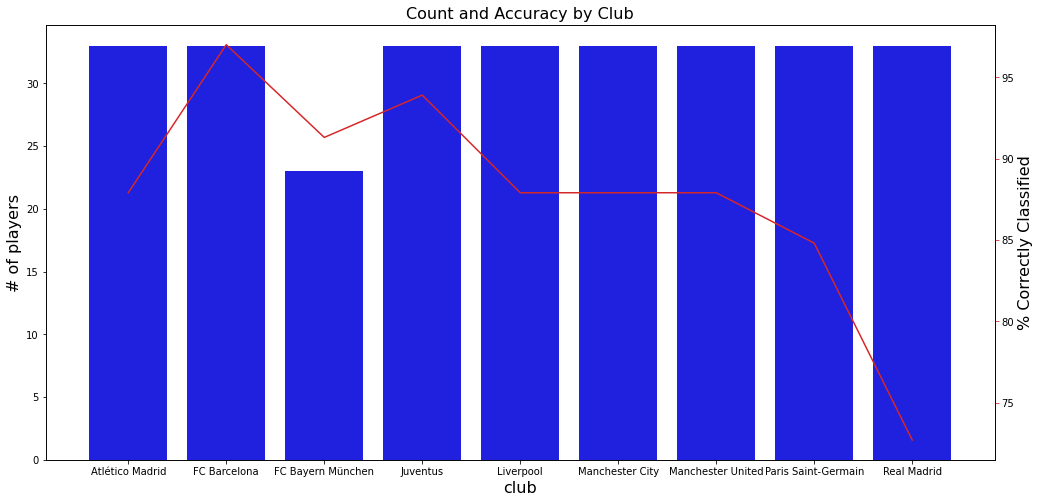

In [254]:
#Create combo chart to show the count of players and accuracy by club
fig, ax1 = plt.subplots(figsize=(17,8))
color = 'tab:green'
#bar plot creation
ax1.set_title('Count and Accuracy by Club', fontsize=16)
ax1.set_xlabel('Club Name', fontsize=16)
ax1.set_ylabel('# of players', fontsize=16)
ax1 = sns.barplot(x="club", y="# of players", data=byclub, color='blue')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('% Correctly Classified', fontsize=16)
ax2 = sns.lineplot(x="club", y="% correctly classified", data=byclub, color = color,markers= True)
ax2.tick_params(axis='y', color=color)
#show plot
plt.show()

#### Observations from the graph above - Real Madrid has the worst accuracy around ~70%; Whereas FC Barcelona we are almost at 100% 

In [258]:
byposition = pd.pivot_table(accuracy_data,index=['player_postion_predicted'],values='One_Correct',aggfunc=[len,np.mean],fill_value=0).reset_index(drop=False)
byposition.columns = ['Predicted Player Position','# of players','% correctly classified']
byposition['% correctly classified'] = round(byposition['% correctly classified']*100,1)
byposition.head(3)

,Predicted Player Position,# of players,% correctly classified
0,CAM,18,72.2
1,CB,43,97.7
2,CDM,8,62.5


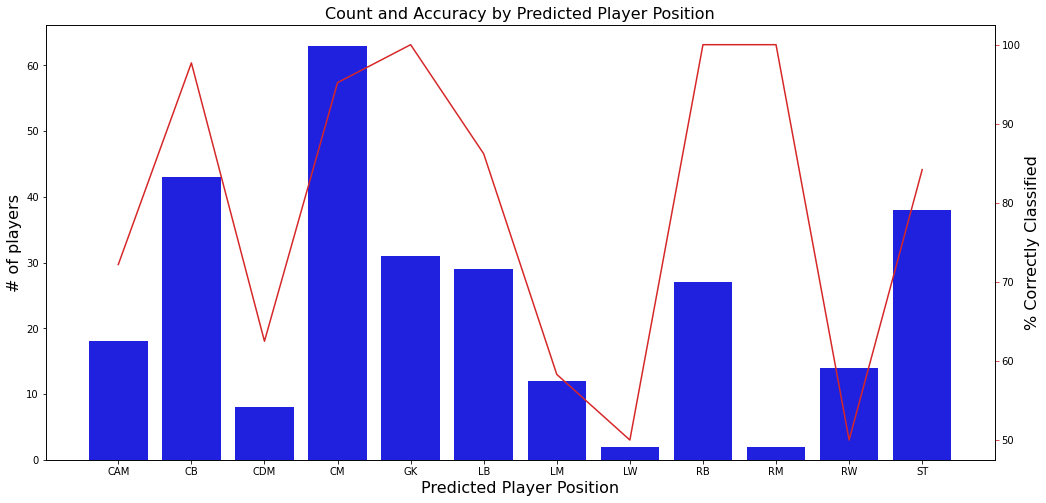

In [260]:
#Create combo chart to show the count of players and accuracy by club
fig, ax1 = plt.subplots(figsize=(17,8))
color = 'tab:green'
#bar plot creation
ax1.set_title('Count and Accuracy by Predicted Player Position', fontsize=16)
ax1.set_xlabel('Predicted Player Position', fontsize=16)
ax1.set_ylabel('# of players', fontsize=16)
ax1 = sns.barplot(x="Predicted Player Position", y="# of players", data=byposition, color='blue')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('% Correctly Classified', fontsize=16)
ax2 = sns.lineplot(x="Predicted Player Position", y="% correctly classified", data=byposition, color = color,markers= True)
ax2.tick_params(axis='y', color=color)
#show plot
plt.show()

#### Observations from the graph above - Postions like Goal keeper, Right Back, Center Middle has above 95% accuracy. Whereas positions with less # of players are predicted somewhat less accuraately. Right Wing seems to the only position with >10 players with very little accuracy. On further drilldown, RW players are getting misclassfied as for Left WInd Players or Right Middle

In [262]:
accuracy_data[accuracy_data.player_postion_predicted=='RW']

,sofifa_id,short_name,player_positions_actual,player_postion_predicted,club,player_positions,One_Correct
0,158023,L. Messi,RW,RW,FC Barcelona,"RW, CF, ST",1
2,190871,Neymar Jr,LW,RW,Paris Saint-Germain,"LW, CAM",0
4,183277,E. Hazard,LW,RW,Real Madrid,"LW, CF",0
5,192985,K. De Bruyne,CAM,RW,Manchester City,"CAM, CM",0
9,209331,M. Salah,RW,RW,Liverpool,"RW, ST",1
20,211110,P. Dybala,CAM,RW,Juventus,"CAM, RW",1
23,202652,R. Sterling,RW,RW,Manchester City,"RW, LW",1
74,231443,O. Dembélé,RW,RW,FC Barcelona,"RW, LW",1
90,204485,R. Mahrez,RW,RW,Manchester City,"RW, RM",1
159,238794,Vinícius Jr.,LW,RW,Real Madrid,LW,0
